# OGGM Hackaton
**24.10.2018**

What I'm trying to do is to implement the orginal model from Ben's paper into the OGGM workflow.

## Import section

In [1]:
# data management modules
import numpy as np
import xarray as xr
import pandas as pd

# oggm modules
import oggm
from oggm import cfg, utils, tasks, workflow, graphics
from oggm.workflow import execute_entity_task

# plotting modules
import matplotlib.pyplot as plt

# force matplotlib to show figures in notebook
%matplotlib inline

## Checking for modularity...
The OGGM is quite modular on paper. Here I want to see what I get from the existing workflow and where or better with what I have to turn onto a new workflow...

For this reason I use the Upper Grindelwald Glacier, since I'm already working on it.

In [2]:
# Initialize OGGM and set up the run parameters
cfg.initialize()

2018-12-10 15:05:40: oggm.cfg: Parameter file: /Users/oberrauch/oggm/oggm/params.cfg


In [3]:
# Local paths (where to write the OGGM run output)
wdir = '/Users/oberrauch/work/hacktoberfest/test_wd'
utils.mkdir(wdir, reset=True)
cfg.PATHS['working_dir'] = wdir
cfg.PARAMS['use_intersects'] = False

In [4]:
# specify RGI ID for the Upper Grindelwald Glacier (UGG)
rgi_id = 'RGI60-11.01270'
# get RGI entry for the UGG
rgidf = utils.get_rgi_glacier_entities([rgi_id], version='61')
rgidf

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,check_geom,geometry
1269,RGI60-11.01270,G008119E46614N,20030799,20030999,8.11933,46.6143,11,1,9.023,1361,...,6412,0,0,0,0,9,9,None,WARN:WasInvalid;,"POLYGON ((8.127299661000052 46.63327544100008,..."


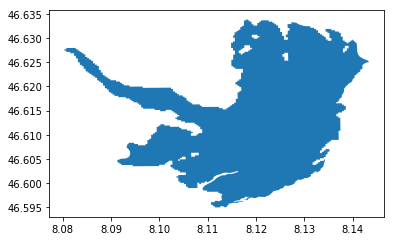

In [5]:
rgidf.plot();

In [6]:
# Go - initialize working directories
gdirs = workflow.init_glacier_regions(rgidf)
# get UGG glacier directory (since I'm working on one glacier only)
gdir = gdirs[0]
# what attributes do we have
gdir

2018-12-10 15:05:41: oggm.workflow: Multiprocessing: using all available processors (N=4)
2018-12-10 15:05:42: oggm.core.gis: (RGI60-11.01270) define_glacier_region


<oggm.GlacierDirectory>
  RGI id: RGI60-11.01270
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 9.023 km2
  Lon, Lat: (8.11933, 46.6143)
  Grid (nx, ny): (132, 123)
  Grid (dx, dy): (52.0, -52.0)

In [7]:
# preprocessing tasks
task_list = [
    tasks.glacier_masks,
    tasks.compute_centerlines,
    tasks.initialize_flowlines,
    tasks.catchment_area,
    tasks.catchment_intersections,
    tasks.catchment_width_geom,
    tasks.catchment_width_correction,
    tasks.compute_downstream_line,
    tasks.compute_downstream_bedshape
]
# execute all tasks
for task in task_list:
    task(gdir)

2018-12-10 15:05:42: oggm.core.gis: (RGI60-11.01270) glacier_masks
2018-12-10 15:05:42: oggm.core.centerlines: (RGI60-11.01270) compute_centerlines
2018-12-10 15:05:42: oggm.core.centerlines: (RGI60-11.01270) initialize_flowlines
2018-12-10 15:05:43: oggm.core.centerlines: (RGI60-11.01270) catchment_area
2018-12-10 15:05:45: oggm.core.centerlines: (RGI60-11.01270) catchment_intersections
2018-12-10 15:05:45: oggm.core.centerlines: (RGI60-11.01270) catchment_width_geom
2018-12-10 15:05:46: oggm.core.centerlines: (RGI60-11.01270) catchment_width_correction
2018-12-10 15:05:46: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_line
2018-12-10 15:05:47: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_bedshape


In [8]:
# use the OGGM climate task to process the climate
tasks.process_cru_data(gdir)

2018-12-10 15:05:47: oggm.core.climate: (RGI60-11.01270) process_cru_data


2018-12-10 15:05:52: oggm.core.climate: (RGI60-11.01270) glacier_mu_candidates


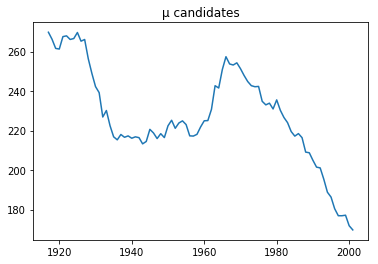

In [9]:
tasks.glacier_mu_candidates(gdir)
mu_candidates = gdir.read_pickle('climate_info')['mu_candidates_glacierwide']
mu_candidates.plot(title='µ candidates');

In [10]:
# set t* and compute mu* for UGG
tasks.local_t_star(gdir)
tasks.mu_star_calibration(gdir)

2018-12-10 15:05:52: oggm.core.climate: (RGI60-11.01270) local_t_star
2018-12-10 15:05:52: oggm.core.climate: (RGI60-11.01270) local mu* for t*=1952
2018-12-10 15:05:52: oggm.core.climate: (RGI60-11.01270) mu_star_calibration


Trying to understand the `test_local_t_star()` unit test.

In [11]:
# read the inversion flowlines
fls = gdir.read_pickle('inversion_flowlines')
fl = fls[-1]

In [12]:
fl.apparent_mb.shape

(59,)

In [13]:
# read the inversion flow lines
fls = gdir.read_pickle('inversion_flowlines')
# create empty containers
mb_on_h = np.array([])
h = np.array([])

In [14]:
fl = fls[-1]

In [15]:
from oggm.core import climate

In [16]:
y, t, p = climate.mb_yearly_climate_on_height(gdir, fl.surface_h)

In [17]:
y.shape

(115,)

In [47]:
# bring into user friendly format
temp = pd.DataFrame(t, columns=y, index=fl.surface_h)
temp.index.name = 'height'
temp.columns.name = 'year'
temp.head()

year,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
height,,,,,,,,,,,,,,,,,,,,,
3545.408114,0.569774,0.000000,3.439176,2.369774,1.250287,0.524958,0.000000,0.000000,0.000000,5.228065,...,0.728065,1.805843,4.216954,3.283620,3.008804,3.982282,5.228065,1.123991,8.848950,5.689690
3503.368115,0.843034,0.075996,3.985696,2.741252,1.796807,0.798218,0.000000,0.000000,0.000000,5.774585,...,1.274585,2.352363,4.763474,3.830141,3.555325,4.802063,5.774586,1.670511,9.668731,6.509470
3445.973244,1.265162,0.449062,4.731829,3.487385,2.542940,1.171285,0.649978,0.271284,0.000000,6.773113,...,2.376817,3.454596,5.873113,4.632373,4.301457,5.921262,6.520719,2.929213,10.787930,7.662547
3396.050776,1.914155,0.773559,5.494750,4.136378,3.191933,1.495781,1.298970,0.595780,0.162447,7.746602,...,3.350306,4.428084,6.938309,5.605862,5.304976,6.894751,7.368825,4.227198,11.761419,8.960532
3361.270409,2.366300,1.177411,6.172967,4.588522,3.644077,1.721853,1.751115,0.821853,0.388519,8.424819,...,4.028523,5.106301,7.842598,6.284079,6.209265,7.709265,8.209266,5.131487,12.439635,9.864821


In [59]:
mu_ref = gdir.read_json('local_mustar')['mu_star_glacierwide']

In [65]:
# read the inversion flow lines
fls = gdir.read_pickle('inversion_flowlines')
# create empty containers
mb_on_h = np.array([])
h = np.array([])
# for each flow line
for fl in fls:
    # get mass balance relevant climate parameters
    # on the elevation of each grid point
    y, t, p = climate.mb_yearly_climate_on_height(gdir, fl.surface_h)
    # compute average value per elevation level
    # over all years with reference mb measurements
    t = np.mean(t[:, :], axis=1)
    p = np.mean(p[:, :], axis=1)
    # compute point mass balance per grid point
    # (i.e. elevation level) and add to container
    mb_on_h = np.append(mb_on_h, p - mu_ref * t)
    # add elevation levels to container
    h = np.append(h, fl.surface_h)

In [76]:
from scipy.stats import linregress
pok = np.where(h < 3100)
lin_reg = linregress(h[pok], mb_on_h[pok])
lin_reg

LinregressResult(slope=10.863415774511251, intercept=-31683.424644879124, rvalue=0.995697973756883, pvalue=7.57776244067232e-68, stderr=0.12636672409984917)

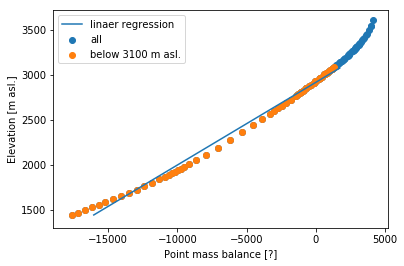

In [99]:
plt.scatter(mb_on_h, h, label='all')
plt.scatter(mb_on_h[pok], h[pok], label='below 3100 m asl.')
h_reg = np.array([h[pok][0], h[pok][-1]])
plt.plot(h_reg*lin_reg.slope+lin_reg.intercept, h_reg, label='linaer regression')

plt.ylabel('Elevation [m asl.]')
plt.xlabel('Point mass balance [?]')
plt.legend()

In [85]:
h_reg

array([3076.29697102, 3024.03031966, 2967.48654768, 2914.52785702,
       2874.26942315, 2849.24781322, 2834.625918  , 2823.56155963,
       2812.19351821, 2799.91886671, 2786.78580391, 2776.40250253,
       3088.21611943, 3068.66411556, 3046.02989596, 3022.19654469,
       3005.12490184, 3068.78125922, 3036.96649288, 3007.89710147,
       2981.2768243 , 2955.96496983, 2931.53876111, 2913.3455472 ,
       3055.88601893, 3009.61874938, 2966.19128841, 2926.58705117,
       2889.04752433, 2850.9837401 , 2810.3692403 , 2767.61039667,
       2725.72125842, 2687.72143177, 2655.44488382, 2627.45229928,
       2598.81425307, 2561.54354242, 2508.3572454 , 2439.30776963,
       2359.93381007, 2274.36785   , 2187.73818421, 2110.27121701,
       2049.54853871, 2005.69362539, 1975.15623304, 1953.5428234 ,
       1936.77202594, 1922.17302715, 1907.30386239, 1889.77138232,
       1866.79018227, 1836.34828779, 1799.73844344, 1760.92230103,
       1723.14199446, 1686.40040442, 1649.25178775, 1612.65347

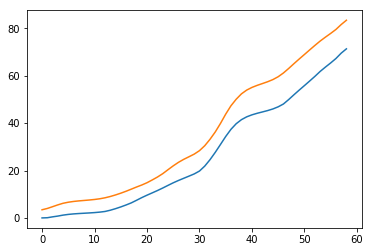

In [39]:
plt.plot(t[:, 1:3])

In [13]:
# read the inversion flowlines
fls = gdir.read_pickle('inversion_flowlines')
# set tmb to zero ?!
tmb = 0.
# for each flowline
for fl in fls:

    self.assertTrue(fl.apparent_mb.shape == fl.widths.shape)
    np.testing.assert_allclose(mu_ref, fl.mu_star, atol=1e-3)
    tmb += np.sum(fl.apparent_mb * fl.widths)
    assert not fl.flux_needs_correction
np.testing.assert_allclose(tmb, 0., atol=0.01)
np.testing.assert_allclose(fls[-1].flux[-1], 0., atol=0.01)

NameError: name 'self' is not defined

In [12]:
gdir.read_json('local_mustar')

{'rgi_id': 'RGI60-11.01270',
 't_star': 1952,
 'bias': 6.194361372145723,
 'mu_star_glacierwide': 221.1396638555171,
 'mu_star_per_flowline': [221.13966385551717,
  221.13966385551717,
  221.13966385551717,
  221.13966385551717],
 'mu_star_flowline_avg': 221.13966385551717,
 'mu_star_allsame': True}

In [13]:
# inversion tasks
tasks.prepare_for_inversion(gdir)
tasks.mass_conservation_inversion(gdir)
tasks.filter_inversion_output(gdir)

2018-11-28 15:25:42: oggm.core.inversion: (RGI60-11.01270) prepare_for_inversion
2018-11-28 15:25:42: oggm.core.inversion: (RGI60-11.01270) mass_conservation_inversion
2018-11-28 15:25:42: oggm.core.inversion: (RGI60-11.01270) filter_inversion_output


### Internal mass balance calibration tasks

In [63]:
from oggm.core import climate

In [71]:
# load the new module
import importlib
from oggm.core import ben
importlib.reload(ben)

<module 'oggm.core.ben' from '/Users/oberrauch/oggm/oggm/core/ben.py'>

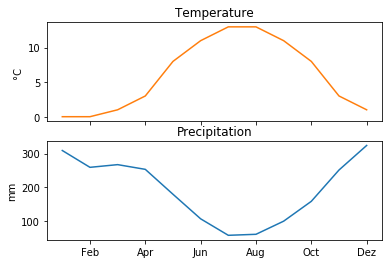

In [51]:
# get climatological monthly values
months, temp, prcp = ben.get_climatological_temp_prcp(gdir)

ax1 = plt.subplot(211)
ax1.plot(months, temp, c='C1')
ax1.set_title('Temperature')
ax1.set_ylabel('°C')
ax1.set_xlim([1,12])
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(months, prcp, c='C0')
ax2.set_title('Precipitation')
ax2.set_ylabel('mm')
ax2.set_xticklabels(['', 'Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dez']);

In [168]:
# get yearly sums
years, temp, prcp = ben.get_yearly_mb_temp_prcp(gdir)

# compute average
yearly_temp_mean = temp.mean()
yearly_prcp_mean = prcp.mean()
print('Average yearly temperature "input": {:.2f} °C'.format(yearly_temp_mean))
print('Average yearly solid precipitation input: {:.0f} mm'.format(yearly_prcp_mean))

Average yearly temperature "input": 89.08 °C
Average yearly solid precipitation input: 2329 mm


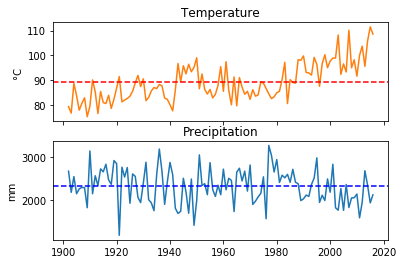

In [170]:
ax1 = plt.subplot(211)
ax1.plot(years, temp, c='C1')
ax1.axhline(yearly_temp_mean, c='r', ls='--')
ax1.set_title('Temperature')
ax1.set_ylabel('°C')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(years, prcp, c='C0')
ax2.axhline(yearly_prcp_mean, c='b', ls='--')
ax2.set_title('Precipitation')
ax2.set_ylabel('mm');

In [253]:
# use the OGGM methode to get the mass balance relevant climate parameters
years_oggm, temp_oggm, prcp_oggm = climate.mb_yearly_climate_on_glacier(gdir)

# compute average
yearly_temp_oggm_mean = temp_oggm.mean()
yearly_prcp_oggm_mean = prcp_oggm.mean()
print('Average yearly temperature "input": {:.2f} °C'.format(yearly_temp_oggm_mean))
print('Average yearly solid precipitation input: {:.0f} mm'.format(yearly_prcp_oggm_mean))

Average yearly temperature "input": 15.04 °C
Average yearly solid precipitation input: 3307 mm


Text(0,0.5,'mm')

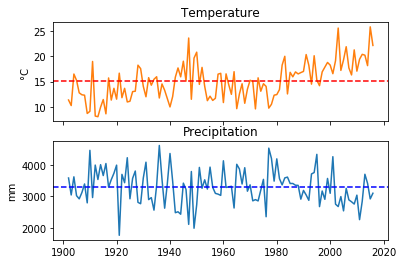

In [171]:
ax1 = plt.subplot(211)
ax1.plot(years_oggm, temp_oggm, c='C1')
ax1.axhline(yearly_temp_oggm_mean, c='r', ls='--')
ax1.set_title('Temperature')
ax1.set_ylabel('°C')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(years_oggm, prcp_oggm, c='C0')
ax2.axhline(yearly_prcp_oggm_mean, c='b', ls='--')
ax2.set_title('Precipitation')
ax2.set_ylabel('mm')

In [166]:
# compute correlation
temp_corr = np.corrcoef(temp, temp_oggm)[0,1]
prcp_corr = np.corrcoef(prcp, prcp_oggm)[0,1]

print(temp_corr)
print(prcp_corr)

0.8225711438664784
0.9484201631127929


In [173]:
# compute differences to mean
temp_diff = temp - yearly_temp_mean
temp_oggm_diff = temp_oggm - yearly_temp_oggm_mean
prcp_diff = prcp - yearly_prcp_mean
prcp_oggm_diff = prcp_oggm - yearly_prcp_oggm_mean
# compute correlation between anomalies
temp_diff_corr = np.corrcoef(temp_diff, temp_oggm_diff)[0,1]
prcp_diff_corr = np.corrcoef(prcp_diff, prcp_oggm_diff)[0,1]

print(temp_diff_corr)
print(prcp_diff_corr)

0.8225711438664787
0.9484201631127931


Use the `yearly_mb_climate_on_height(...)` for better comparison.

In [261]:
# get relevant elevation information
fpath = gdir.get_filepath('gridded_data')
with ncDataset(fpath) as nc:
    mask = nc.variables['glacier_mask'][:]
    topo = nc.variables['topo'][:]
min_elev = np.min(topo[np.where(mask == 1)])
max_elev = np.max(topo[np.where(mask == 1)])

heights = np.array([min_elev])
years_height, temp_height, _ = climate.mb_yearly_climate_on_height(gdir, heights, flatten=False)
temp_height = temp_height[0]

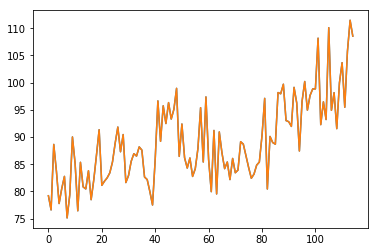

In [262]:
plt.plot(temp_height)
plt.plot(temp)

In [198]:
temp_term_corr = np.corrcoef(temp, temp_height)[0,1]
print(temp_term_corr)

1.0


In [263]:
np.testing.assert_allclose(temp, temp_height)

The positive melting temperature corresponds perfectly to the OGGM reference.

In [217]:
# read elevtion levels and corresponding widths
flowlines = gdir.read_pickle('inversion_flowlines')

heights = np.array([])
widths = np.array([])
for fl in flowlines:
    heights = np.append(heights, fl.surface_h)
    widths = np.append(widths, fl.widths)
    
years_height, _, prcp_height = climate.mb_yearly_climate_on_height(gdir, heights, flatten=True)

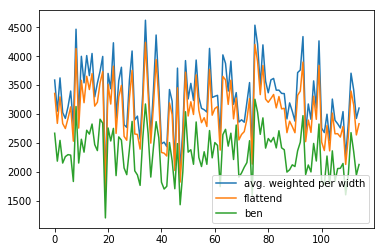

In [218]:
plt.plot(prcp_oggm, label='avg. weighted per width')
plt.plot(prcp_height, label='flattend')
plt.plot(prcp, label='ben')
plt.legend()

In [256]:
prcp_df = pd.DataFrame(np.transpose([prcp_oggm, prcp_height, prcp]), index=years, columns=['oggm', 'flatten', 'ben'])
prcp_df.corr().loc['ben']

0.9724044265743877

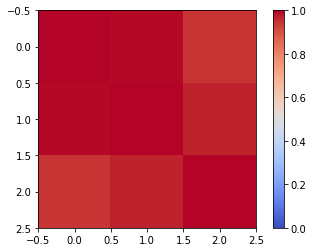

In [252]:
plt.imshow(prcp_df.corr(), vmin=0, vmax=1, cmap='coolwarm')
plt.colorbar()

Dig deeper (changed the function so that it returns the monthly values, therefore it may not be working here...)

In [122]:
# get monthly values
years, temp, prcp = ben.get_yearly_mb_temp_prcp(gdir)

In [123]:
# compute average over hydrological year
temp_yr = np.zeros(int(len(temp)/12))
prcp_yr = np.zeros(int(len(temp)/12))

for i, y in enumerate(temp_yr):
    temp_yr[i] = np.mean(temp[i * 12:(i + 1) * 12])
    prcp_yr[i] = np.mean(prcp[i * 12:(i + 1) * 12])

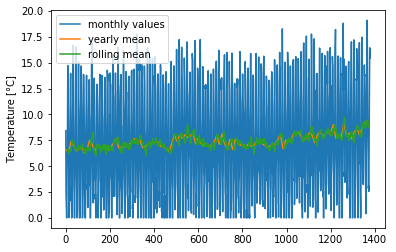

In [128]:
index = np.arange(temp.size)
plt.plot(index, temp, label='monthly values')
plt.plot(index[::12], temp_yr, label='yearly mean')
temp_df = pd.Series(temp, index=index)
plt.plot(temp_df.rolling(12, center=True).mean(), label='rolling mean')

plt.ylabel('Temperature [°C]')
plt.legend()

In [129]:
from oggm.core import climate
importlib.reload(climate)

<module 'oggm.core.climate' from '/Users/oberrauch/oggm/oggm/core/climate.py'>

In [130]:
# changed the functions in order to get monthly values per height level
years_oggm, temp_oggm, prcp_oggm = climate.mb_yearly_climate_on_glacier(gdir)

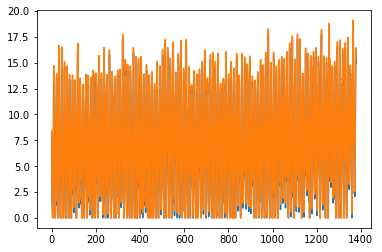

In [135]:
temp_terminus = temp_oggm[-1]
plt.plot(temp_terminus)
plt.plot(temp)

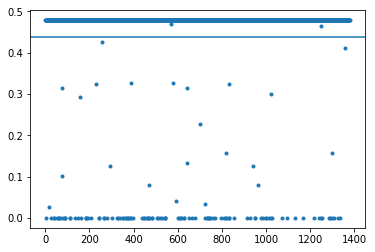

In [139]:
plt.plot(abs(temp_terminus - temp), ls='None', marker='.')
plt.axhline(np.mean(abs(temp_terminus - temp)))

In [144]:
np.sum(temp_terminus - temp)/temp.size

-0.4376325524371603

In [140]:
# compute average over hydrological year
temp_yr = np.zeros(int(len(temp)/12))
temp_terminus_yr = np.zeros(int(len(temp)/12))

for i, y in enumerate(temp_yr):
    temp_yr[i] = np.sum(temp[i * 12:(i + 1) * 12])
    temp_terminus_yr[i] = np.sum(temp_terminus[i * 12:(i + 1) * 12])

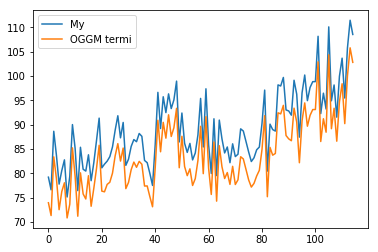

In [142]:
plt.plot(temp_yr, label='My')
plt.plot(temp_terminus_yr, label='OGGM termi')
plt.legend()

## µ* computation

In [148]:
# load the new module
import importlib
from oggm.core import climate
from oggm.core import ben
importlib.reload(climate)
importlib.reload(ben)

<module 'oggm.core.ben' from '/Users/oberrauch/oggm/oggm/core/ben.py'>

In [149]:
# interpolate the local t* and
# compute the corresponding µ*
ben.local_t_star(gdir)

In [150]:
gdir.read_json('ben_params')

{'rgi_id': 'RGI60-11.01270',
 't_star': 1952,
 'bias': 6.194361372145723,
 'mu_star': 32.68571428571428}

## The new (simpler) mass balance model

In [159]:
# load the OGGM mass balance module
import importlib
from oggm.core import massbalance, ben
importlib.reload(ben)

<module 'oggm.core.ben' from '/Users/oberrauch/oggm/oggm/core/ben.py'>

First thing I did is to copy the existing ``PastMassBalance`` model, since it is based on the original mass balance model. But then, calling ``massbalance.OriginalMassBalance(gdir)`` results in an error. The problem is that the ``local_mustar`` file is not available. The same happens for the ``PastMassBalance`` (most obviously). So some (climate) calibration step is missing...

EDIT: now I'm missing the ``mb_calib_params`` in the ``climate_info`` file.
EDIT 2: Turns out, I'm an idiot!

In [152]:
years = np.arange(1915, 2012)

In [157]:
year = 2000
past_mbmod.get_specific_mb(year=year)

TypeError: len() of unsized object

In [153]:
# create instances of the mass balance model
past_mbmod = massbalance.PastMassBalance(gdir)
# compute monthly mb with PastMassBalance model
past_mb_tmp = [past_mbmod.get_specific_mb(year=year) for year in years] 
past_mb_tmp = [monthly_mb.mean() for monthly_mb in past_mb_tmp]
plt.plot(dates, past_mb_tmp)

TypeError: len() of unsized object

In [158]:
# compute monthly mb with PastMassBalance model
past_mb_tmp = [past_mbmod.get_specific_mb(heights, year=year) for year in years] 
past_mb_tmp = [monthly_mb.mean() for monthly_mb in past_mb_tmp]

NameError: name 'heights' is not defined

In [311]:
# compute monthly mb with PastMassBalance model
ben_mb_tmp = [ben_mbmod.get_specific_mb(heights, year=year) for year in years]

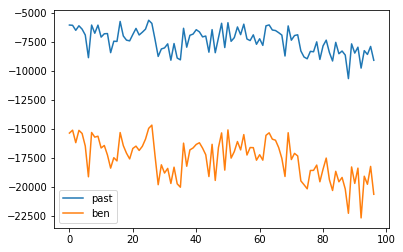

In [312]:
plt.plot(past_mb_tmp, label='past')
plt.plot(ben_mb_tmp, label='ben')
plt.legend()

Text(0,0.5,'ben')

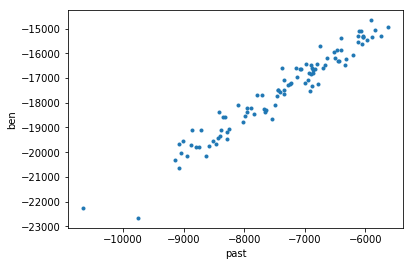

In [313]:
plt.plot(past_mb_tmp, ben_mb_tmp, ls='None', marker='.')
plt.xlabel('past')
plt.ylabel('ben')

In [22]:
# set t* and compute mu* for UGG
ben.local_t_star(gdir)

In [23]:
gdir.read_json('ben_params')

{'rgi_id': 'RGI60-11.01270',
 't_star': 1952,
 'bias': 6.194361372145723,
 'mu_star': 27.570400676261688}

In [24]:
# inversion tasks
tasks.prepare_for_inversion(gdir)
tasks.mass_conservation_inversion(gdir)
tasks.filter_inversion_output(gdir)

2018-10-24 17:51:02: oggm.core.inversion: (RGI60-11.01270) prepare_for_inversion
2018-10-24 17:51:02: oggm.core.inversion: (RGI60-11.01270) mass_conservation_inversion
2018-10-24 17:51:02: oggm.core.inversion: (RGI60-11.01270) filter_inversion_output


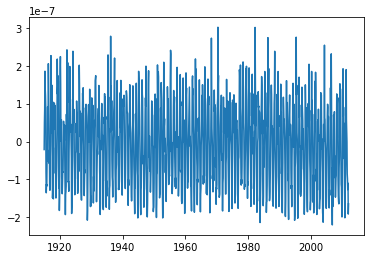

In [25]:
# create instances of the mass balance model
ben_mbmod = ben.OriginalMassBalance(gdir)
# compute monthly mb with PastMassBalance model
ben_mb_tmp = [ben_mbmod.get_monthly_mb(heights, year=date) for date in dates] 
plt.plot(dates, ben_mb_tmp)

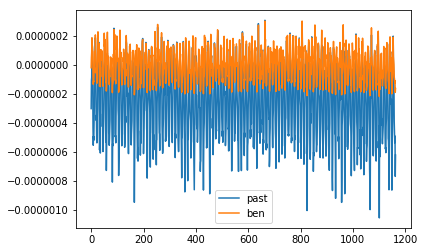

In [29]:
plt.plot(past_mb_tmp, label='past')
plt.plot(ben_mb_tmp, label='ben')
plt.legend()

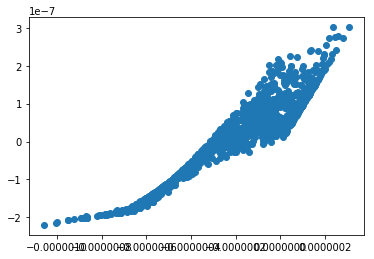

In [27]:
plt.plot(past_mb_tmp, ben_mb_tmp, ls='None', marker='o')

In [413]:
# set t* and compute mu* for UGG
tasks.local_t_star(gdir)
tasks.mu_star_calibration(gdir)

2018-10-24 17:42:31: oggm.core.climate: (RGI60-11.01270) local_t_star
2018-10-24 17:42:31: oggm.core.climate: (RGI60-11.01270) local mu* for t*=1952
2018-10-24 17:42:31: oggm.core.climate: (RGI60-11.01270) mu_star_calibration


In [414]:
# reload module to get latest version
importlib.reload(ben)
# create instances of the mass balance models
ben_mbmod = ben.OriginalMassBalance(gdir)

In [415]:
ben.local_t_star(gdir)

In [416]:
gdir.read_json('ben_params')

{'rgi_id': 'RGI60-11.01270',
 't_star': 1952,
 'bias': 6.194361372145723,
 'mu_star': 27.570400676261688}

In [410]:
years

array([1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947,
       1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967])

In [411]:
temp_yr

array([[87.60333252, 82.64703369, 82.18148041, 79.96517944, 77.50222015,
        85.93184662, 96.64778137, 89.21110535, 95.74369812, 92.48814392,
        96.33481598, 93.31443787, 95.10332489, 98.95889282, 86.44776917,
        92.39851379, 86.18740082, 84.29852295, 86.14777374, 82.75814056,
        84.16591644, 87.88962555, 95.40332794, 85.41444397, 97.38111115,
        85.87850952, 79.95703125, 91.21333313, 79.53592682, 90.9437027 ,
        87.09220886],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.04210997,  1.99766588,  1.25359297,  0.20914841,
         3.05125904,  0.        ,  0.99670267,  1.89803743,  0.        ,
         2.10681391,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.96470404,  0.        ,  0.52322149,
         0.74211073,  0.        ,  0.68692589,  0.        ,  0.        ,
         0.83137035]])

In [412]:
prcp_yr

array([[ 947.91271973,  928.0916748 ,  990.5244751 , 1012.53845215,
        1012.09466553,  642.23400879,  564.87609863,  783.31903076,
         841.60272217,  583.83074951,  891.17987061,  490.46307373,
         661.30200195,  400.57556152, 1318.77197266,  869.59918213,
         631.64068604,  614.13256836, 1136.18713379,  504.39416504,
         270.81362915, 1063.52355957,  469.93383789,  681.16394043,
         488.07962036,  984.4720459 , 1509.88891602,  676.48486328,
         882.53186035,  447.70651245,  872.43762207],
       [4748.57568359, 4113.16015625, 4480.67236328, 5497.04882812,
        4422.46972656, 3890.76586914, 3710.86987305, 3348.56079102,
        4741.70849609, 4733.79492188, 3170.83764648, 4973.01269531,
        3049.78369141, 4056.83374023, 5270.51513672, 4325.69580078,
        4664.11425781, 4462.27929688, 5132.66601562, 4629.87548828,
        4315.16796875, 4520.04736328, 4248.85839844, 5424.27148438,
        4451.22509766, 4015.6237793 , 4482.38671875, 3811.1083

In [377]:
tstar = 1952
mu_hp = 15
yr = [tstar - mu_hp, tstar + mu_hp]
months, temp_terminus, prcpsol = ben.get_climatological_monthly_params(gdir, heights, year_range=yr)

In [384]:
gdir.get_filepath('gridded_data')

'/Users/oberrauch/work/hacktoberfest/test_wd/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01270/gridded_data.nc'

In [356]:
pok = np.where(time.month == 12)

AttributeError: 'numpy.ndarray' object has no attribute 'month'

In [315]:
# define some testing parameters
dates = np.arange(1915, 2012, 1/12)
heights = rgidf[['Zmin', 'Zmax']].values[0]
heights

array([1361, 3682])

In [316]:
# compute monthly mb with PastMassBalance model
past_mb_tmp = [past_mbmod.get_monthly_mb(heights, year=date) for date in dates] 
past_mb_tmp = [monthly_mb.mean() for monthly_mb in past_mb_tmp]

In [317]:
# compute monthly mb with PastMassBalance model
ben_mb_tmp = [ben_mbmod.get_monthly_mb(heights, year=date) for date in dates]

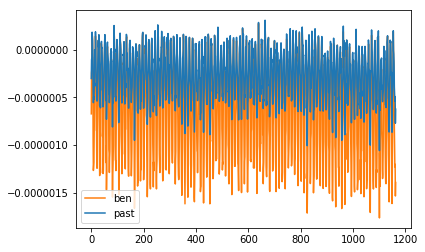

In [323]:
plt.plot(ben_mb_tmp, label='ben', c='C1')
plt.plot(past_mb_tmp, label='past', c='C0')
plt.legend()

Text(0,0.5,'ben')

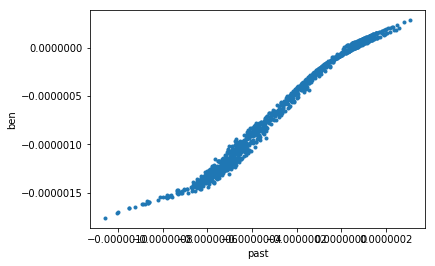

In [319]:
plt.plot(past_mb_tmp, ben_mb_tmp, ls='None', marker='.')
plt.xlabel('past')
plt.ylabel('ben')

In [309]:
years = np.arange(1915, 2012)

In [310]:
# compute monthly mb with PastMassBalance model
past_mb_tmp = [past_mbmod.get_specific_mb(heights, year=year) for year in years] 
past_mb_tmp = [monthly_mb.mean() for monthly_mb in past_mb_tmp]

In [311]:
# compute monthly mb with PastMassBalance model
ben_mb_tmp = [ben_mbmod.get_specific_mb(heights, year=year) for year in years]

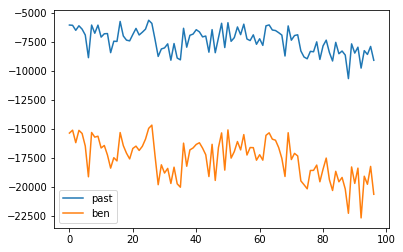

In [312]:
plt.plot(past_mb_tmp, label='past')
plt.plot(ben_mb_tmp, label='ben')
plt.legend()

Text(0,0.5,'ben')

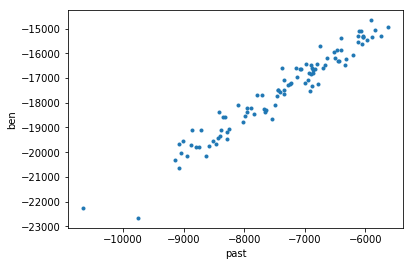

In [313]:
plt.plot(past_mb_tmp, ben_mb_tmp, ls='None', marker='.')
plt.xlabel('past')
plt.ylabel('ben')

In [201]:
60*60*24*31*365

977616000